In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import featuretools as ft

from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,KFold,RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from sklearn.metrics import auc,roc_curve,roc_auc_score,accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

from scipy.stats import randint


In [3]:
file_path = '/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/15 Model Engineering/use_case_1/PSP_Jan_Feb_2019.csv'

In [4]:
psp = pd.read_csv(file_path,sep=';',index_col=False)

# Index-Spalte löschen 
psp=psp.drop(psp.columns[0], axis=1)

In [5]:
psp.sample(5)

,tmsp,country,amount,success,PSP,3D_secured,card
18534,2019-01-21 22:50:14,Germany,220,0,UK_Card,0,Master
43520,2019-02-20 04:56:50,Austria,121,0,Moneycard,1,Master
19718,2019-01-23 09:18:00,Switzerland,206,0,UK_Card,0,Master
13798,2019-01-15 18:56:21,Switzerland,82,1,Moneycard,1,Master
15567,2019-01-17 21:57:45,Germany,184,0,Goldcard,0,Diners


# EDA 

In [140]:
psp.shape

(50410, 7)

In [141]:
psp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tmsp        50410 non-null  object
 1   country     50410 non-null  object
 2   amount      50410 non-null  int64 
 3   success     50410 non-null  int64 
 4   PSP         50410 non-null  object
 5   3D_secured  50410 non-null  int64 
 6   card        50410 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.7+ MB


In [217]:
# Nach Leerzeichen in String-Zellen suchen
whitespace_values = psp.applymap(lambda x: isinstance(x, str) and x.isspace())

rows_with_true = whitespace_values[whitespace_values.any(axis=1)]

# Ergebnis anzeigen
print(rows_with_true)

Empty DataFrame
Columns: [tmsp, country, amount, success, PSP, 3D_secured, card]
Index: []


In [72]:
psp_verteilung = psp['PSP'].value_counts(normalize=True) * 100

print(psp_verteilung)

UK_Card       52.487602
Simplecard    24.689546
Moneycard     16.459036
Goldcard       6.363817
Name: PSP, dtype: float64


In [73]:
psp.describe()

,amount,success,3D_secured,fee
count,50410.000000,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266,1.756477
std,96.274730,0.402160,0.426027,1.814051
min,6.000000,0.000000,0.000000,0.500000
25%,133.000000,0.000000,0.000000,1.000000
50%,201.000000,0.000000,0.000000,1.000000
75%,269.000000,0.000000,0.000000,2.000000
max,630.000000,1.000000,1.000000,10.000000


# ToDo: Ausreißer chekcen!!!!

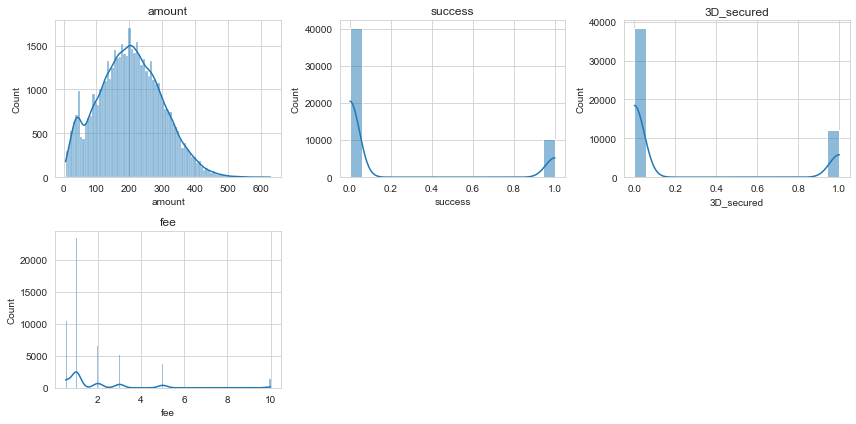

In [75]:
def plot_distplots(dataframe, numeric_columns):
    number_of_columns = 3
    number_of_rows = math.ceil((len(numeric_columns) - 1) / number_of_columns)

    plt.figure(figsize=(4 * number_of_columns, 6 * number_of_rows))
    
    for i, column in enumerate(numeric_columns):
        plt.subplot(number_of_rows + 1, number_of_columns, i + 1)
        sns.set_style('whitegrid')
        sns.histplot(dataframe[column], kde=True)
        plt.title(column)
    
    plt.tight_layout()
    plt.show()

# Beispielaufruf
plot_distplots(psp, psp.select_dtypes(include='number').columns)

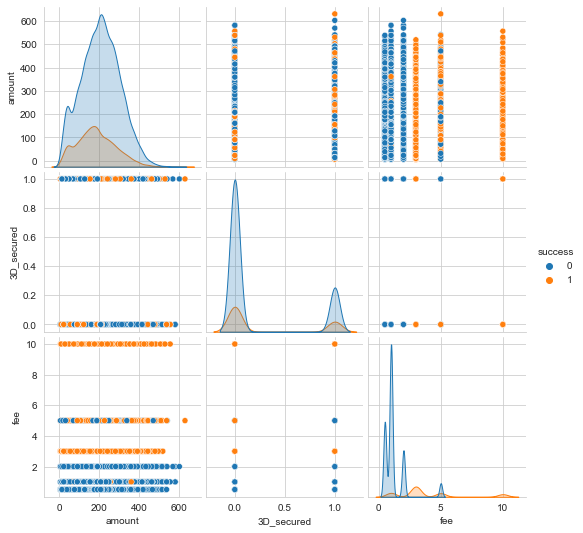

In [76]:
sns.pairplot(psp,hue='success')

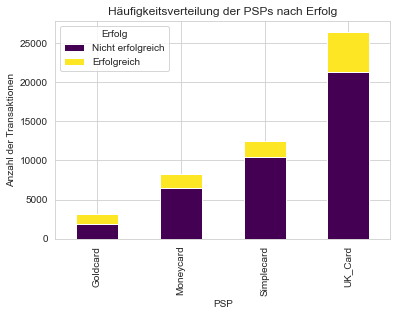

In [78]:
psp_success_counts = psp.groupby(['PSP', 'success']).size().unstack(fill_value=0)

# Gestapeltes Balkendiagramm erstellen
psp_success_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Häufigkeitsverteilung der PSPs nach Erfolg')
plt.xlabel('PSP')
plt.ylabel('Anzahl der Transaktionen')
plt.legend(title='Erfolg', labels=['Nicht erfolgreich', 'Erfolgreich'])
plt.show()


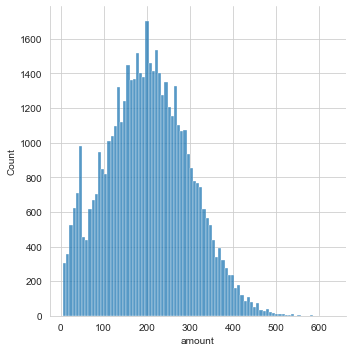

In [79]:
sns.displot(psp['amount'])

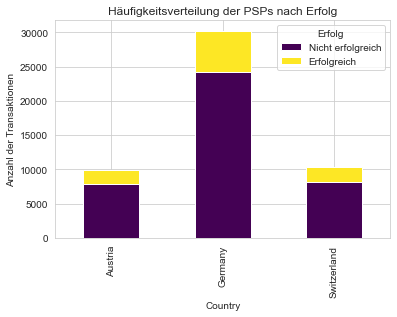

In [80]:
country_success_counts = psp.groupby(['country', 'success']).size().unstack(fill_value=0)

# Gestapeltes Balkendiagramm erstellen
country_success_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Häufigkeitsverteilung der PSPs nach Erfolg')
plt.xlabel('Country')
plt.ylabel('Anzahl der Transaktionen')
plt.legend(title='Erfolg', labels=['Nicht erfolgreich', 'Erfolgreich'])
plt.show()

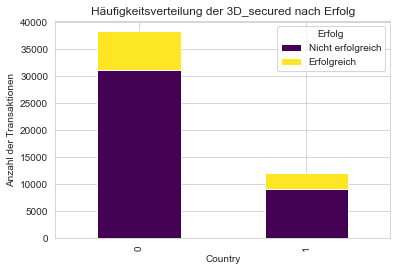

In [81]:
country_success_counts = psp.groupby(['3D_secured', 'success']).size().unstack(fill_value=0)

# Gestapeltes Balkendiagramm erstellen
country_success_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Häufigkeitsverteilung der 3D_secured nach Erfolg')
plt.xlabel('Country')
plt.ylabel('Anzahl der Transaktionen')
plt.legend(title='Erfolg', labels=['Nicht erfolgreich', 'Erfolgreich'])
plt.show()

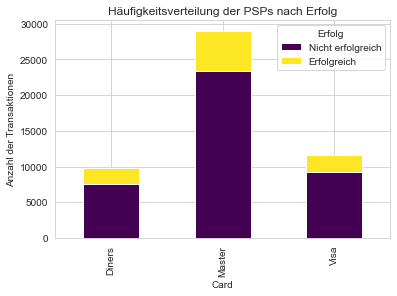

In [82]:
card_success_counts = psp.groupby(['card', 'success']).size().unstack(fill_value=0)

# Gestapeltes Balkendiagramm erstellen
card_success_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Häufigkeitsverteilung der PSPs nach Erfolg')
plt.xlabel('Card')
plt.ylabel('Anzahl der Transaktionen')
plt.legend(title='Erfolg', labels=['Nicht erfolgreich', 'Erfolgreich'])
plt.show()

In [83]:
numeric_columns = psp.select_dtypes(include='number')
categorical_columns = psp.select_dtypes(include='object')

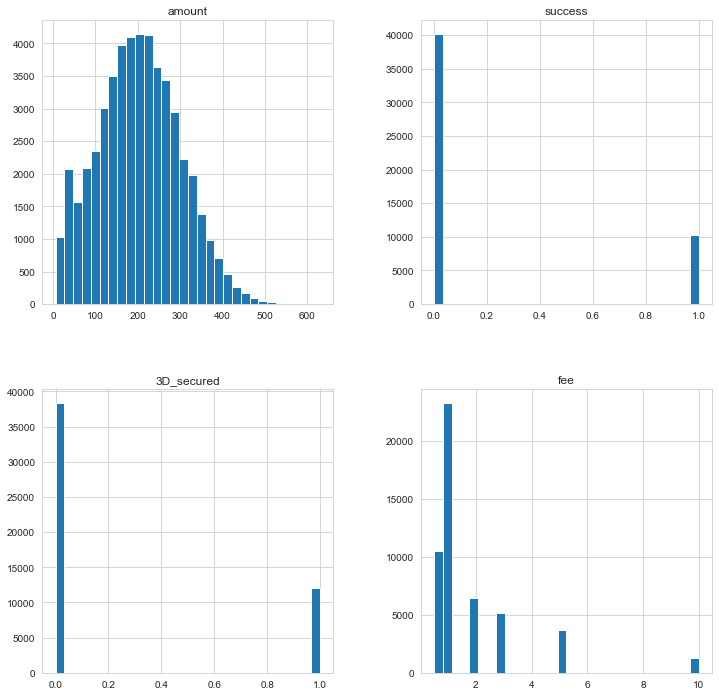

In [84]:
numeric_columns.hist(figsize=(12,12),bins=30)
plt.show()

In [85]:
categorical_columns.describe(include='object')

,tmsp,country,PSP,card
count,50410,50410,50410,50410
unique,50121,3,4,3
top,2019-02-12 03:30:54,Germany,UK_Card,Master
freq,3,30233,26459,29002


# Multivariate Analysis

In [86]:

# Annahme: 'datensatz' ist der DataFrame, der deine Daten enthält
korrelation = psp['3D_secured'].corr(psp['success'])

print(f"Korrelation zwischen '3D_secured' und 'success': {korrelation}")


Korrelation zwischen '3D_secured' und 'success': 0.05928394865359395


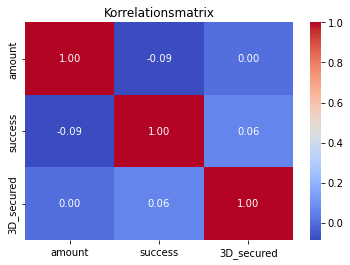

In [139]:
correlation_matrix = psp.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korrelationsmatrix')
plt.show()


# Datenaufbereitung / Preprocessing

## Encoding

In [5]:
### OneHot-Encoding bzw LabelEncoder -> ausprobieren!! 
psp_encoded_oh = pd.get_dummies(psp,columns=['PSP','country','card'])
psp_encoded_oh.sample(3)

,tmsp,amount,success,3D_secured,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
46282,2019-02-23 18:46:03,183,1,0,0,1,0,0,1,0,0,0,1,0
40193,2019-02-15 20:58:18,232,0,0,0,0,0,1,1,0,0,0,1,0
20840,2019-01-24 18:31:00,298,0,1,0,0,0,1,0,1,0,1,0,0


In [6]:
### LabelEncoder
# Instanziieren des LabelEncoders
label_encoder_country = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_psp = LabelEncoder()

psp_encoded_LE = psp.copy()
# Die Spalten mit LabelEncoder transformieren
psp_encoded_LE['country'] = label_encoder_country.fit_transform(psp_encoded_LE['country'])
psp_encoded_LE['card'] = label_encoder_card.fit_transform(psp_encoded_LE['card'])
psp_encoded_LE['PSP'] = label_encoder_psp.fit_transform(psp_encoded_LE['PSP'])



In [6]:
# Erstelle ein Dictionary mit den entsprechenden Verschlüsselungen
encoding_dict = dict(zip(label_encoder_psp.classes_, label_encoder_psp.transform(label_encoder_psp.classes_)))

# Ausgabe des Dictionaries
print(encoding_dict)

{'Goldcard': 0, 'Moneycard': 1, 'Simplecard': 2, 'UK_Card': 3}


In [7]:
psp_encoded_LE.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,1,89,0,3,0,2
1,2019-01-01 00:01:17,1,89,1,3,0,2
2,2019-01-01 00:02:49,1,238,0,3,1,0
3,2019-01-01 00:03:13,1,238,1,3,1,0
4,2019-01-01 00:04:33,0,124,0,2,0,0


In [8]:
# Dekodierung der kodierten Werte
psp_decoded_LE = psp_encoded_LE.copy()

# Dekodierung der 'country'-Spalte
psp_decoded_LE['country'] = label_encoder_country.inverse_transform(psp_decoded_LE['country'])

# Dekodierung der 'card'-Spalte
psp_decoded_LE['card'] = label_encoder_card.inverse_transform(psp_decoded_LE['card'])

# Dekodierung der 'PSP'-Spalte
psp_decoded_LE['PSP'] = label_encoder_psp.inverse_transform(psp_decoded_LE['PSP'])

psp_decoded_LE.head()


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


## Timestamp in Features

In [7]:
# timestamp in pd-Format
psp_encoded_LE['tmsp'] = pd.to_datetime(psp_encoded_LE['tmsp'])

psp_encoded_LE['year'] = psp_encoded_LE['tmsp'].dt.year
psp_encoded_LE['month'] = psp_encoded_LE['tmsp'].dt.month
psp_encoded_LE['day'] = psp_encoded_LE['tmsp'].dt.day
psp_encoded_LE['weekday'] = psp_encoded_LE['tmsp'].dt.weekday #0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'
psp_encoded_LE['hour'] = psp_encoded_LE['tmsp'].dt.hour



In [8]:
psp_encoded_LE.drop(['tmsp'],axis=1, inplace=True)
psp_encoded_LE.sample(5)

,country,amount,success,PSP,3D_secured,card,year,month,day,weekday,hour
27292,1,139,0,3,0,1,2019,2,1,4,21
9396,1,79,0,3,0,1,2019,1,10,3,8
21492,0,205,0,3,0,1,2019,1,25,4,15
21928,1,38,1,3,0,1,2019,1,26,5,7
5918,1,265,0,3,0,2,2019,1,6,6,15


# Modellentwicklung (Baseline)

## Aufteilen in Training- und Testdaten

In [9]:
# Aufteilung der Daten in Trainings- und Testsets
# label encoder 
X = psp_encoded_LE.drop(['success'], axis=1)
y = psp_encoded_LE['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  ## evtl stratify parameter! -> aber wichtiger: verteilung des splits anschauen für kleinere kategorien

# Stratified KFold

In [ ]:
# label encoder 
X = psp_encoded_LE.drop(['success'], axis=1)
y = psp_encoded_LE['success']

# Anzahl der Folds für die stratifizierte k-Fold Cross-Validation
k = 5  # Anzahl der Folds

# Initialisierung des stratifizierten KFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


# Durchführung der stratifizierten k-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
# Baseline-Modell erstellen (vorhersagen der häufigsten Klasse)
baseline_model = DummyClassifier(strategy='stratified')

# Modell auf den Trainingsdaten trainieren
baseline_model.fit(X_train, y_train)



DummyClassifier(strategy='stratified')

In [11]:
# Vorhersagen für die Testdaten machen
pred = baseline_model.predict(X_test)

# Genauigkeit des Baseline-Modells berechnen
genauigkeit = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f"Genauigkeit des Baseline-Modells: acc:{genauigkeit}, precision: {precision}, recall:{recall}, f1:{f1}")



Genauigkeit des Baseline-Modells: acc:0.672981551279508, precision: 0.19884448724121329, recall:0.20185728250244378, f1:0.200339558573854


In [12]:
roc_auc_score(y_test, pred)

0.4973945446857665

In [30]:
confusion_matrix(y_test, pred)

array([[6452, 1710],
       [1553,  367]])

## Prod Modell

## DecisionTree

In [25]:
# Modellauswahl und Training

dt_classifier = tree.DecisionTreeClassifier()
#model = LogisticRegression()
dt_classifier.fit(X_train, y_train)


DecisionTreeClassifier()

In [26]:
# Modellbewertung
dt_predictions = dt_classifier.predict(X_test)
dt_proba = dt_classifier.predict_proba(X_test)

In [17]:
dt_proba[:,1]

array([0. , 0. , 0. , ..., 1. , 0. , 0.5])

## Kfold

In [20]:
# label encoder 
X = psp_encoded_LE.drop(['success'], axis=1)
y = psp_encoded_LE['success']

# Anzahl der Folds für die stratifizierte k-Fold Cross-Validation
k = 5  # Anzahl der Folds

# Initialisierung des Klassifikators (hier: Entscheidungsbaum)
classifier = DecisionTreeClassifier()

# Initialisierung des stratifizierten KFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Listen zur Speicherung der Ergebnisse
scores = []

# Durchführung der stratifizierten k-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Modell trainieren
    classifier.fit(X_train, y_train)
    
    # Vorhersagen machen
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Genauigkeit berechnen und speichern
    auc = roc_auc_score(y_test, y_proba)
    scores.append(auc)

# Durchschnittliche Genauigkeit berechnen
average_auc = np.mean(scores)
print("Durchschnittliche AUC:", average_auc)

Durchschnittliche AUC: 0.535031905580543


In [28]:
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("f1:", f1_score(y_test, dt_predictions,average="weighted"))
print("AUC:",roc_auc_score(y_test, dt_predictions))
#print(confusion_matrix(y_test, dt_predictions))#
#print(classification_report(y_test, dt_predictions))

Accuracy: 0.718210672485618
f1: 0.7106780700784858
AUC: 0.5401574512932275


In [35]:
print(roc_auc_score(y_test, dt_predictions))

0.538225286898636


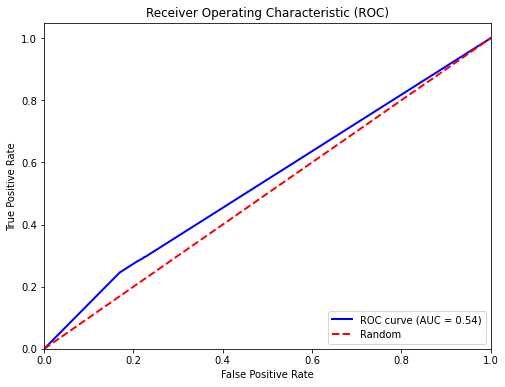

In [36]:
# Mache Vorhersagen auf den Testdaten
y_scores = dt_classifier.predict_proba(X_test)[:, 1]

# Berechne die ROC-Kurve und den AUC-Wert
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Zeichne die ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## RandomForest

In [21]:
rf_classifier = RandomForestClassifier(random_state=42)
#RandomForestClassifier(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 10)
#RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Modellbewertung
rf_predictions = rf_classifier.predict(X_test)
rf_proba = rf_classifier.predict_proba(X_test)[:, 1]

In [29]:
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("f1:", f1_score(y_test, rf_predictions,average="weighted"))
print("AUC:",roc_auc_score(y_test, rf_proba))

Accuracy: 0.7647292203927792
f1: 0.7202954696665952
AUC: 0.6324614138624479


In [21]:
confusion_matrix(y_test, rf_predictions)

array([[8112,   50],
       [1844,   76]])

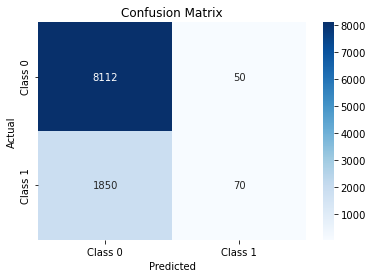

In [232]:
cm = confusion_matrix(y_test, rf_predictions)

# Confusion Matrix mit seaborn anzeigen
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## KFold

In [19]:
# label encoder 
X = psp_encoded_LE.drop(['success'], axis=1)
y = psp_encoded_LE['success']

# Anzahl der Folds für die stratifizierte k-Fold Cross-Validation
k = 5  # Anzahl der Folds

# Initialisierung des Klassifikators (hier: Entscheidungsbaum)
classifier = RandomForestClassifier(n_estimators= 100, min_samples_split= 10, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 10)


# Initialisierung des stratifizierten KFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Listen zur Speicherung der Ergebnisse
scores = []

# Durchführung der stratifizierten k-Fold Cross-Validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Modell trainieren
    classifier.fit(X_train, y_train)
    
    # Vorhersagen machen
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Genauigkeit berechnen und speichern
    auc = roc_auc_score(y_test, y_proba)
    scores.append(auc)

# Durchschnittliche Genauigkeit berechnen
average_auc = np.mean(scores)
print("Durchschnittliche AUC:", average_auc)

Durchschnittliche AUC: 0.6722600038682957


## Feature Importance

In [1]:


# Feature Importance berechnen
feature_importance = rf_classifier.feature_importances_

# Indizes der sortierten Feature Importance
sorted_indices = np.argsort(feature_importance)[::-1]

# Namen der Features
feature_names = X.columns  # Ersetze 'deine_feature_namen' durch die Namen deiner Features

# Die wichtigsten n Features anzeigen
n = 3  # Anzahl der Features, die du anzeigen möchtest
print("Die wichtigsten", n, "Variablen:")
for i in range(n):
    print(f"{i+1}. {feature_names[sorted_indices[i]]}: {feature_importance[sorted_indices[i]]}")


NameError: name 'rf_classifier' is not defined

### RandomizedSearchCV

In [20]:
# Definiere den Suchraum für Hyperparameter
params = {
    'n_estimators': [50, 100, 150],  # Anzahl der Bäume im Wald
    'max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Beispielen, die erforderlich sind, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4],  # Minimale Anzahl von Beispielen in einem Blattknoten
    'max_features': ['auto', 'sqrt', 'log2']  # Maximale Anzahl von Features, die für den besten Split berücksichtigt werden sollen
}

In [21]:
# Definiere den Suchraum für Hyperparameter
params = {
    'n_estimators': [50, 100, 150],  # Anzahl der Bäume im Wald
    'max_depth': [None, 10, 20, 30],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Beispielen, die erforderlich sind, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4],  # Minimale Anzahl von Beispielen in einem Blattknoten
    'max_features': ['auto', 'sqrt', 'log2']  # Maximale Anzahl von Features, die für den besten Split berücksichtigt werden sollen
}


# Initialisiere KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisiere den RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, params, n_iter=40, cv=kf, scoring='roc_auc', random_state=42)

# Führe die Hyperparameter-Optimierung durch
random_search.fit(X_train, y_train)

# Zeige die besten Hyperparameter
print("Beste Hyperparameter:", random_search.best_params_)

# Evaluieren des besten Modells auf dem Testdatensatz
best_model = random_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score des besten Modells auf Testdaten:", roc_auc)

Beste Hyperparameter: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
ROC AUC Score des besten Modells auf Testdaten: 0.6806577929735358


## GradientBoostingClassifier

In [18]:
# Definiere den Suchraum für Hyperparameter
params = {
    'n_estimators': [50, 100, 150],  # Anzahl der Bäume im Boosting
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Lernrate
    'max_depth': [3, 5, 7, 9],  # Maximale Tiefe der Bäume
    'min_samples_split': [2, 5, 10],  # Minimale Anzahl von Beispielen, die erforderlich sind, um einen Knoten zu teilen
    'min_samples_leaf': [1, 2, 4],  # Minimale Anzahl von Beispielen in einem Blattknoten
    'max_features': ['auto', 'sqrt', 'log2']  # Maximale Anzahl von Features, die für den besten Split berücksichtigt werden sollen
}


# Initialisiere KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisiere den RandomizedSearchCV
random_search = RandomizedSearchCV(GradientBoostingClassifier(), params, n_iter=40, cv=kf, scoring='roc_auc', random_state=42)

# Führe die Hyperparameter-Optimierung durch
random_search.fit(X_train, y_train)

# Zeige die besten Hyperparameter
print("Beste Hyperparameter:", random_search.best_params_)

# Evaluieren des besten Modells auf dem Testdatensatz
best_model = random_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score des besten Modells auf Testdaten:", roc_auc)

Beste Hyperparameter: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.1}
ROC AUC Score des besten Modells auf Testdaten: 0.6846029044658172


In [14]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, min_samples_leaf=1, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, random_state=42)

In [15]:
gb_proba = gb.predict_proba(X_test)[:,1]
gb_pred = gb.predict(X_test)

In [17]:
print("Accuracy:", accuracy_score(y_test, gb_pred))
print("f1:", f1_score(y_test, gb_pred,average="weighted"))
print("AUC",roc_auc_score(y_test, gb_proba))

Accuracy: 0.7911128744296767
f1: 0.7439869520127878
AUC 0.6532984090398595


##  XGboost

In [22]:
xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [23]:
xgb_proba = xgb.predict_proba(X_test)

In [24]:
xgb_pred = xgb.predict(X_test)

In [25]:
print(roc_auc_score(y_test, xgb_pred))

0.5266878267173078


# Fachliche Logik

In [26]:
# DF erstellen mit den Fees
data = [
    ['Moneycard', 0, 2],
    ['Moneycard', 1, 5],
    
    ['UK_Card', 0, 1],
    ['UK_Card', 1, 3],
    
    ['Simplecard', 0, 0.5],
    ['Simplecard', 1, 1],

    ['Goldcard', 0, 5],
    ['Goldcard', 1, 10]
]

# Spaltennamen
columns = ['PSP', 'SUCCESS', 'FEE']

# DataFrame erstellen
fee_df = pd.DataFrame(data, columns=columns)
fee_df.head(8)

,PSP,SUCCESS,FEE
0,Moneycard,0,2.0
1,Moneycard,1,5.0
2,UK_Card,0,1.0
3,UK_Card,1,3.0
4,Simplecard,0,0.5
5,Simplecard,1,1.0
6,Goldcard,0,5.0
7,Goldcard,1,10.0


In [236]:
# Ausgabe des Dictionaries
print(encoding_dict)

{'Goldcard': 0, 'Moneycard': 1, 'Simplecard': 2, 'UK_Card': 3}


In [27]:
# Kodiere die 'PSP'-Spalte im FEE-DataFrame um später zu verbinden mit probability
fee_df['PSP_encoded'] = label_encoder_psp.transform(fee_df['PSP'])
fee_df = fee_df.sort_values(by='PSP_encoded')
# Ergebnis anzeigen
print(fee_df)

          PSP  SUCCESS   FEE  PSP_encoded
6    Goldcard        0   5.0            0
7    Goldcard        1  10.0            0
0   Moneycard        0   2.0            1
1   Moneycard        1   5.0            1
4  Simplecard        0   0.5            2
5  Simplecard        1   1.0            2
2     UK_Card        0   1.0            3
3     UK_Card        1   3.0            3


In [128]:
# Beispiel TestData für Testen
df_xt = X_test.iloc[:50]
df_xt

,country,amount,PSP,3D_secured,card,year,month,day,weekday,hour
5087,0,215,3,0,1,2019,1,5,5,14
22530,1,240,2,0,0,2019,1,27,6,4
15518,2,382,3,1,1,2019,1,17,3,20
3418,1,32,3,1,1,2019,1,3,3,21
36168,0,211,3,0,1,2019,2,11,0,8
40382,0,245,3,0,1,2019,2,16,5,2
4193,0,211,3,1,0,2019,1,4,4,15
36100,1,249,1,1,1,2019,2,11,0,6
30235,1,270,2,1,1,2019,2,4,0,18
26511,1,320,3,0,0,2019,2,1,4,4


In [121]:
# Berechne WK für jeden PSP

def calculateProba():
    probas=[]
    
    # Für jeden PSP im Datenpunkt WK vorhersagen
    for psp in range(0,4):
        df_xt['PSP']= psp
        # Pro PSP und Success=0/1 füge in Liste hinzu
        proba_0 = rf_classifier.predict_proba(df_xt)[:,0]
        proba_1 = rf_classifier.predict_proba(df_xt)[:,1]
        probas.extend(proba_0)
        probas.extend(proba_1)
        #print(f"WK für Success bei PSP {psp}:", proba_1)
    return(probas)

   
    

In [122]:
calculateProba()

[0.6491095336057349,
 0.3508904663942653,
 0.8175248809640904,
 0.18247511903590916,
 0.8854563576930495,
 0.11454364230695076,
 0.9150961203078982,
 0.08490387969210181]

In [124]:
def choose_best_psp(proba, fee_df):

    # Gewichte initialisieren
    success_weight=0.6
    fee_weight=  -0.4
    success_threshold = 0.8
    
    # Füge die Erfolgswahrscheinlichkeit (proba) zum Gebühren-Datensatz hinzu
    fee_df['Probability'] = proba
    #print(fee_df.head(8))
    
    
    # Filtere den DataFrame, um nur die Zeilen mit Success=1 zu behalten
    fee_df_success_1 = fee_df[fee_df['SUCCESS'] == 1]
    
    # Gruppiere nach PSP und sortiere nach der höchten Proba
    best_psp = fee_df_success_1.groupby('PSP').agg({'Probability': 'max', 'FEE': 'min'}).reset_index()

    
    
    # Überprüfe, ob eine Erfolgswahrscheinlichkeit größer als der Schwellenwert ist
    for index, row in best_psp.iterrows():
        if row['Probability'] > success_threshold:
            return row['PSP']  # Wähle den PSP direkt aus dem DataFrame
            
    
    
    # Falls alle unter threshold liegen:
    
    # Berechne einen kombinierten Score, der die Erfolgswahrscheinlichkeit und die Gebühren berücksichtigt
    best_psp['Combined_Score'] = success_weight * best_psp['Probability'] + fee_weight * best_psp['FEE']
    
    print(best_psp)
    
    # Wähle den PSP mit dem höchsten kombinierten Score
    best_psp = best_psp.loc[best_psp['Combined_Score'].idxmax()]
    
    return best_psp['PSP']
        
                  
